In [20]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
constructors = pd.read_csv('data_raw/constructors.csv')
constructor_results = pd.read_csv('data_raw/constructor_results.csv')
pit_stops = pd.read_csv('data_raw/pit_stops.csv')
results = pd.read_csv('data_raw/results.csv')
lap_times = pd.read_csv('data_raw/lap_times.csv')


In [21]:
# Merge the datasets
merged_data = pd.merge(constructor_results, constructors, on='constructorId', how='left')

# Filter data for the years 2011 to 2023
merged_data = merged_data[(merged_data['raceId'] >= 841) & (merged_data['raceId'] <= 1120)]  # Adjust raceId range as needed

# Clean the data
# Handle missing values in the points column
merged_data['points'] = pd.to_numeric(merged_data['points'], errors='coerce').fillna(0)

# Group by constructor name and calculate total points
constructor_points = merged_data.groupby('name')['points'].sum().reset_index()

# Rename columns for clarity
constructor_points.rename(columns={'name': 'constructor_name', 'points': 'total_points'}, inplace=True)

# Sort by total points for better visualization
constructor_points.sort_values(by='total_points', ascending=False, inplace=True)

constructor_points

,constructor_name,total_points
14,Mercedes,6599.5
16,Red Bull,5633.5
5,Ferrari,4776.5
13,McLaren,2154.0
6,Force India,1017.0
21,Williams,923.0
10,Lotus F1,706.0
17,Renault,532.0
19,Toro Rosso,431.0
2,Alpine F1 Team,328.0


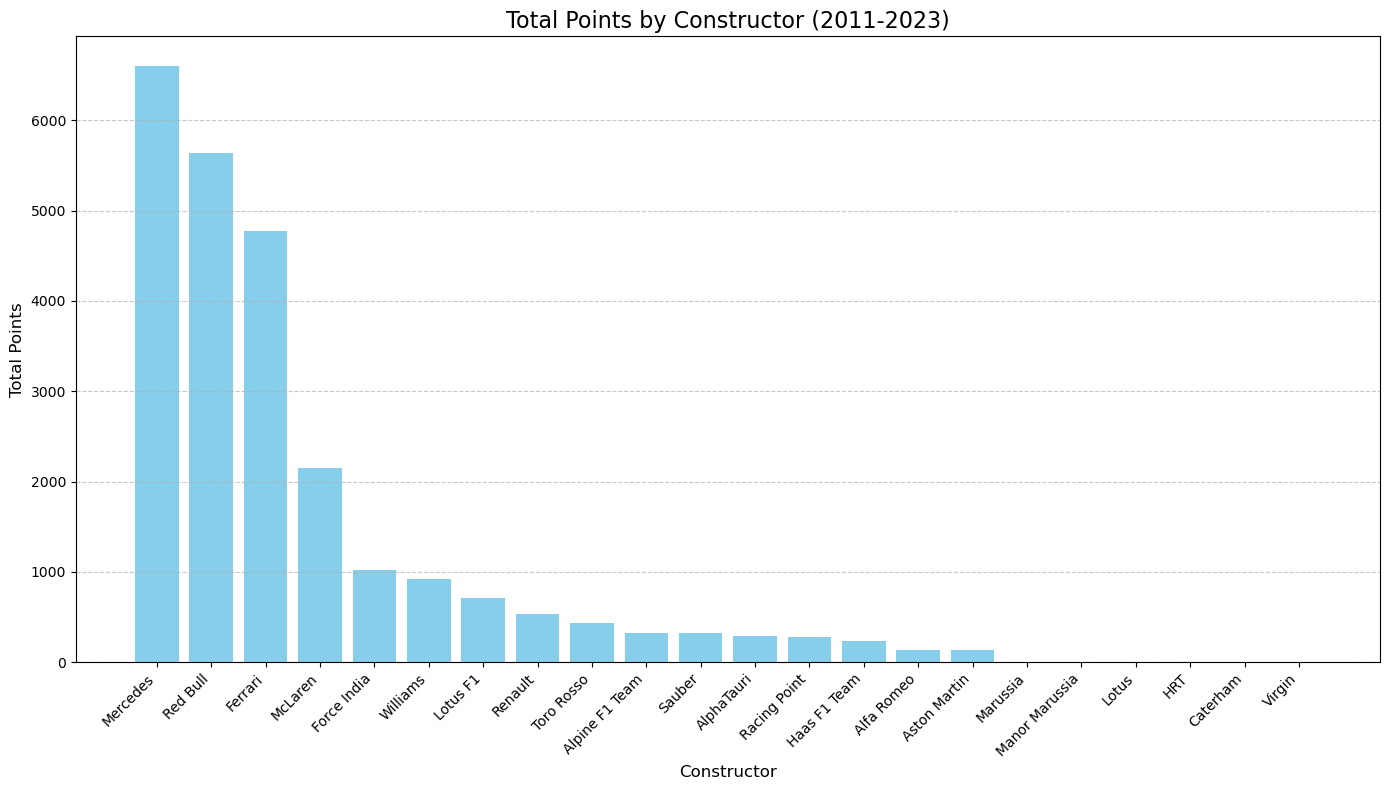

In [22]:
# Plot the data as a bar plot
plt.figure(figsize=(14, 8))
plt.bar(constructor_points['constructor_name'], constructor_points['total_points'], color='skyblue')
plt.title('Total Points by Constructor (2011-2023)', fontsize=16)
plt.xlabel('Constructor', fontsize=12)
plt.ylabel('Total Points', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [23]:
# Merge pit_stops with results to associate races and constructors
merged_data = pd.merge(pit_stops, results, on=['raceId', 'driverId'], how='inner')

# Merge with constructors to get constructor names
merged_data = pd.merge(merged_data, constructors, on='constructorId', how='left')

# Filter data for the years 2011 to 2023
merged_data = merged_data[(merged_data['raceId'] >= 841) & (merged_data['raceId'] <= 1200)]

# Calculate total pit stops for each constructor
total_pit_stops = merged_data.groupby('name')['stop'].count().reset_index()

# Calculate total races each constructor participated in
total_races = merged_data.groupby('name')['raceId'].nunique().reset_index()

# Merge total pit stops and total races
constructor_stats = pd.merge(total_pit_stops, total_races, on='name')
constructor_stats.rename(columns={'stop': 'total_pit_stops', 'raceId': 'total_races'}, inplace=True)

# Calculate average pit stops per game
constructor_stats['avg_pit_stops_per_game'] = constructor_stats['total_pit_stops'] / constructor_stats['total_races']

# Rename columns for clarity
constructor_stats.rename(columns={'name': 'constructor_name'}, inplace=True)

# Sort by average pit stops for better visualization
constructor_stats.sort_values(by='avg_pit_stops_per_game', ascending=False, inplace=True)

constructor_stats

,constructor_name,total_pit_stops,total_races,avg_pit_stops_per_game
9,Lotus,85,18,4.722222
4,Caterham,241,55,4.381818
12,Marussia,233,54,4.314815
7,HRT,150,36,4.166667
20,Virgin,77,19,4.052632
21,Williams,950,237,4.008439
11,Manor Marussia,156,39,4.000000
16,Red Bull,942,239,3.941423
18,Sauber,621,158,3.930380
14,Mercedes,935,238,3.928571


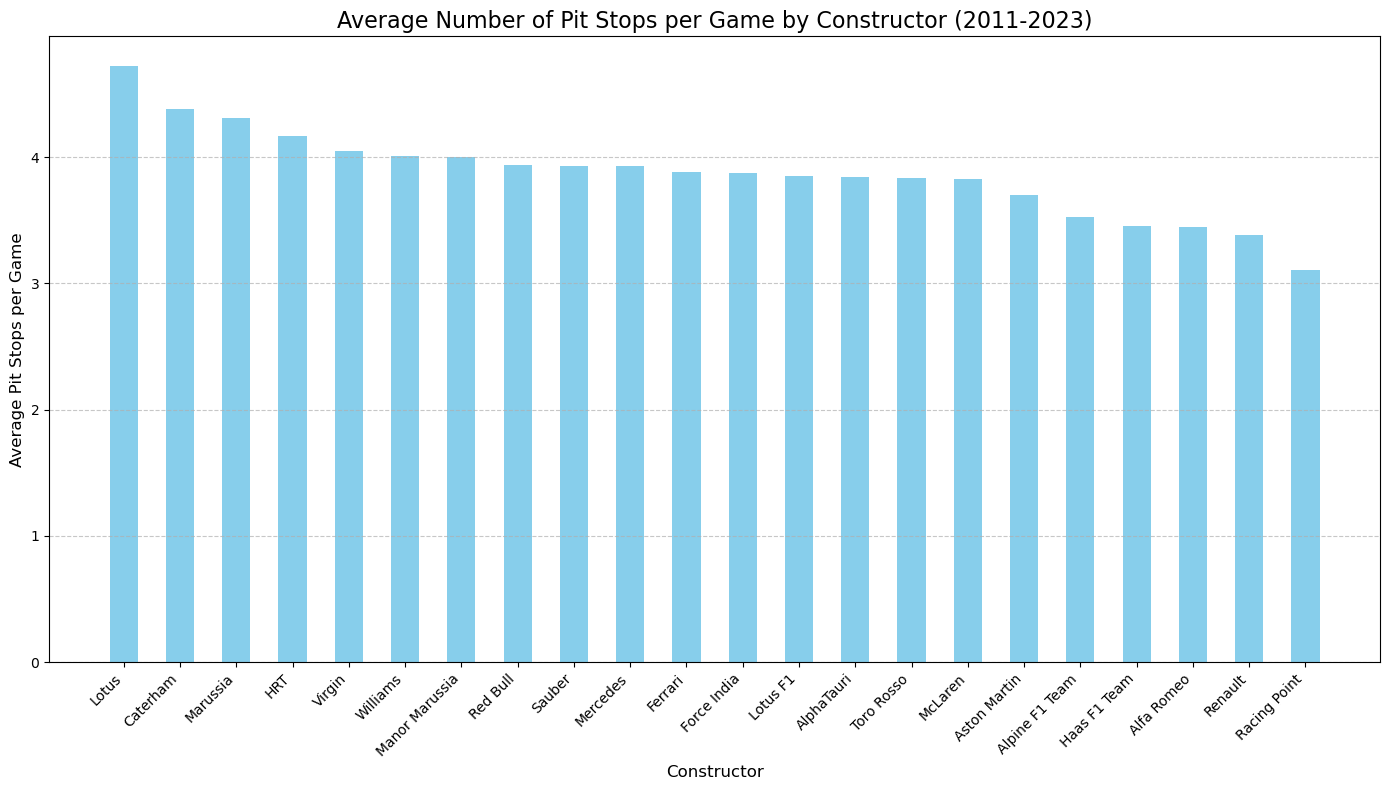

In [24]:
# Plot the data
plt.figure(figsize=(14, 8))
plt.bar(constructor_stats['constructor_name'], constructor_stats['avg_pit_stops_per_game'], color='skyblue', width=0.5)
plt.title('Average Number of Pit Stops per Game by Constructor (2011-2023)', fontsize=16)
plt.xlabel('Constructor', fontsize=12)
plt.ylabel('Average Pit Stops per Game', fontsize=12)


plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [25]:
results['grid']          = pd.to_numeric(results['grid'], errors='coerce')
results['positionOrder'] = pd.to_numeric(results['positionOrder'], errors='coerce')

# Change in race position (+ = places gained)
results['change_in_position'] = results['grid'] - results['positionOrder']

# Pit-stop count per driver-race
pit_stop_counts = (
    pit_stops
      .groupby(['raceId', 'driverId'])
      .size()
      .reset_index(name='pit_stop_count')
)

# Merge with results to add constructor + position change
driver_data = (
    pit_stop_counts
      .merge(results[['raceId', 'driverId', 'constructorId', 'change_in_position']],
             on=['raceId', 'driverId'],
             how='inner')
      .merge(constructors[['constructorId', 'name']], on='constructorId', how='left')
)

# Filter to DRS era (2011-2023) — adjust raceId range if needed
driver_data = driver_data[(driver_data['raceId'] >= 841) & (driver_data['raceId'] <= 1200)]

# Average metrics per constructor
constructor_stats1 = (
    driver_data
      .groupby('name')
      .agg(avg_pit_stops          = ('pit_stop_count', 'mean'),
           avg_change_in_position = ('change_in_position', 'mean'))
      .reset_index()
)

constructor_stats1

,name,avg_pit_stops,avg_change_in_position
0,Alfa Romeo,1.811688,0.435065
1,AlphaTauri,2.045045,-0.864865
2,Alpine F1 Team,1.873418,0.835443
3,Aston Martin,1.939024,1.231707
4,Caterham,2.434343,2.232323
5,Ferrari,2.071749,0.069507
6,Force India,2.064407,0.793220
7,HRT,2.238806,2.656716
8,Haas F1 Team,1.878327,-0.368821
9,Lotus,2.361111,1.166667


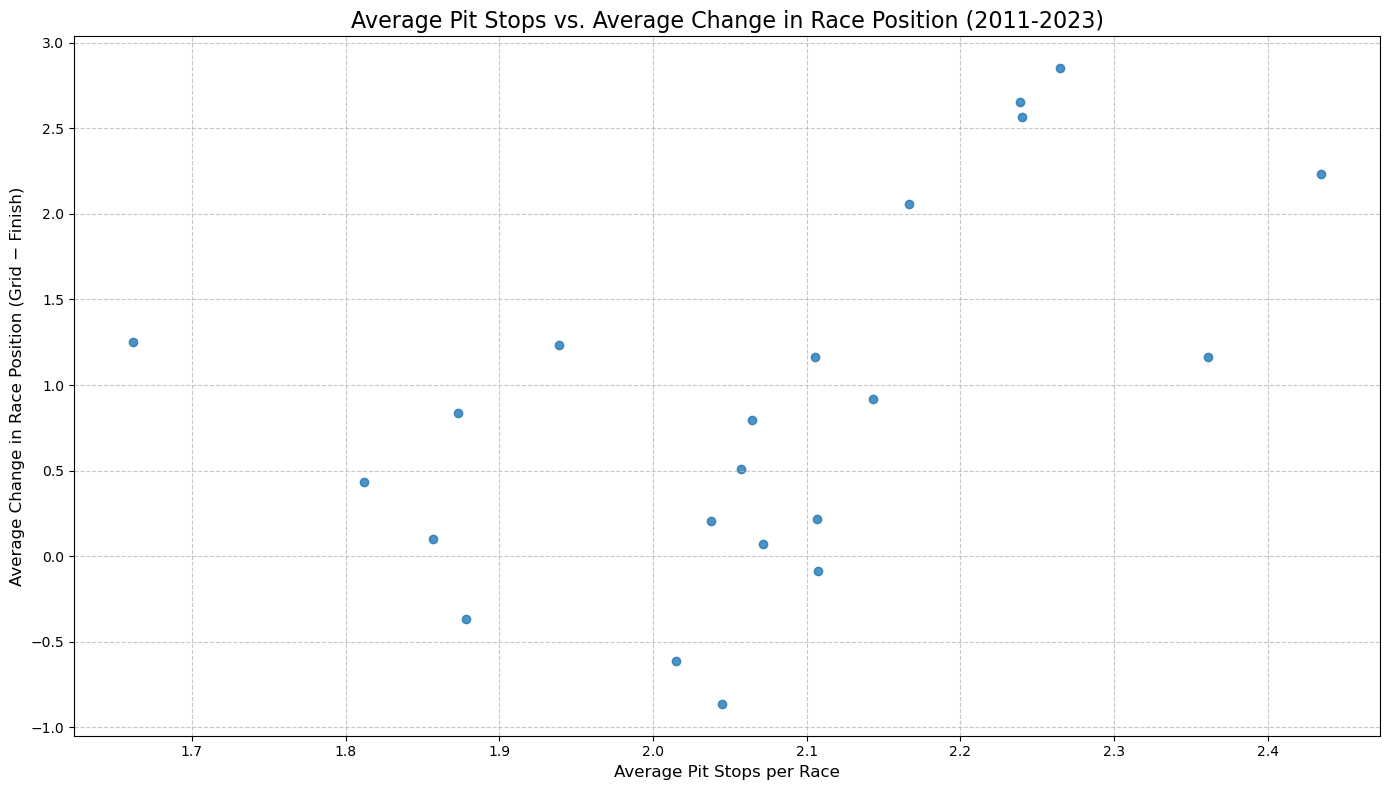

In [26]:
# ── Plot ────────────────────────────────────────────────────────
plt.figure(figsize=(14, 8))
plt.scatter(constructor_stats1['avg_pit_stops'],
            constructor_stats1['avg_change_in_position'],
            alpha=0.8)
plt.title('Average Pit Stops vs. Average Change in Race Position (2011-2023)', fontsize=16)
plt.xlabel('Average Pit Stops per Race', fontsize=12)
plt.ylabel('Average Change in Race Position (Grid − Finish)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [27]:
pit_stops['milliseconds'] = pd.to_numeric(pit_stops['milliseconds'], errors='coerce')
results['grid']           = pd.to_numeric(results['grid'], errors='coerce')
results['positionOrder']  = pd.to_numeric(results['positionOrder'], errors='coerce')

# driver-race metrics
driver_metrics = (
    pit_stops.groupby(['raceId', 'driverId'])['milliseconds'].mean()
    .reset_index(name='avg_pit_stop_ms')
    .merge(
        results.assign(change_in_position = results['grid'] - results['positionOrder'])
               [['raceId','driverId','constructorId','change_in_position']],
        on=['raceId','driverId']
    )
    .merge(constructors[['constructorId','name']], on='constructorId')
    .query('841 <= raceId <= 1200')        # DRS era filter
)

# constructor aggregates
constructor_stats2 = (
    driver_metrics.groupby('name')
    .agg(avg_pit_time_ms        = ('avg_pit_stop_ms','mean'),
         avg_change_position    = ('change_in_position','mean'))
    .reset_index()
)

constructor_stats2

,name,avg_pit_time_ms,avg_change_position
0,Alfa Romeo,112414.162554,0.435065
1,AlphaTauri,140557.493994,-0.864865
2,Alpine F1 Team,148138.206118,0.835443
3,Aston Martin,130893.461789,1.231707
4,Caterham,29820.589394,2.232323
5,Ferrari,62518.006016,0.069507
6,Force India,44478.394689,0.793220
7,HRT,33055.399751,2.656716
8,Haas F1 Team,76871.368251,-0.368821
9,Lotus,24663.530556,1.166667


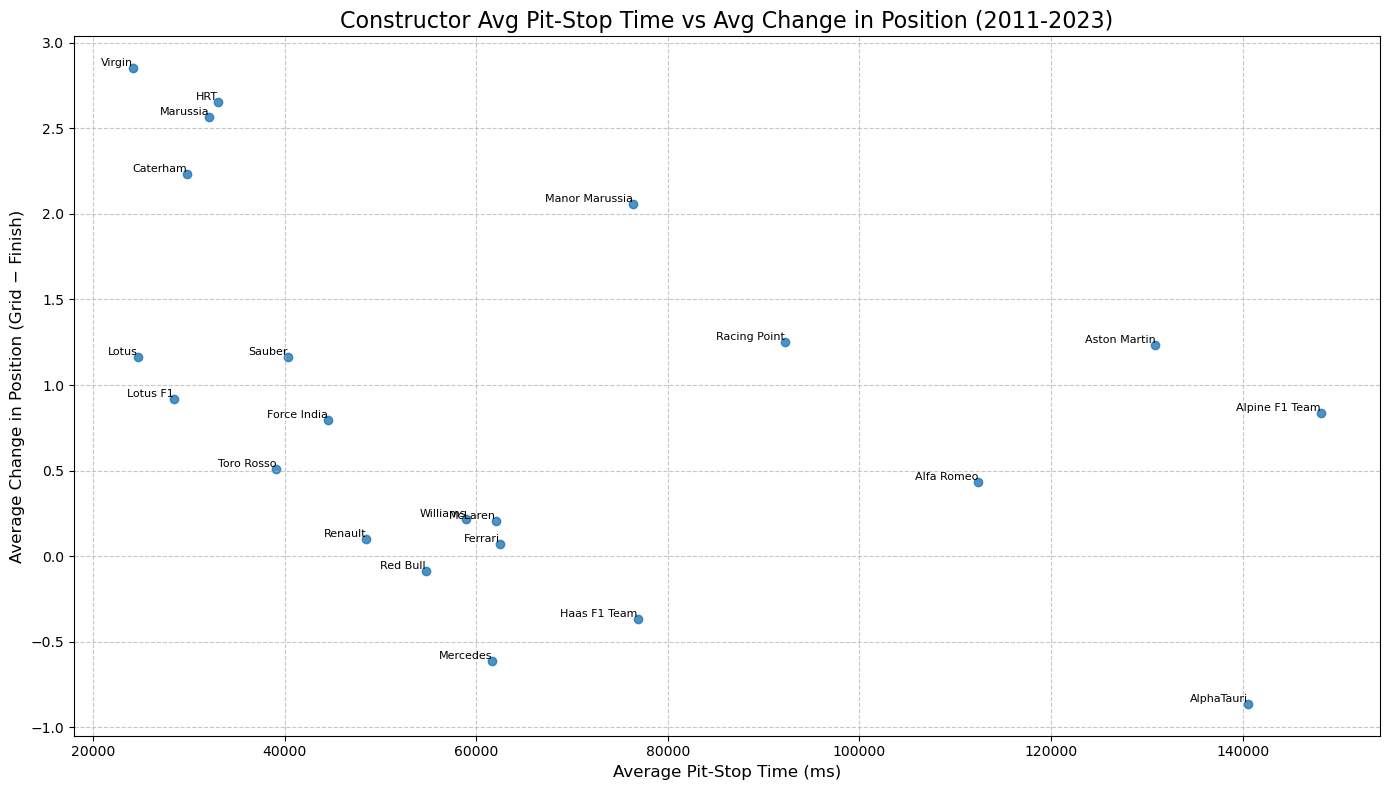

In [28]:
# plot
plt.figure(figsize=(14,8))
plt.scatter(constructor_stats2.avg_pit_time_ms,
            constructor_stats2.avg_change_position,
            alpha=0.8)

for _, r in constructor_stats2.iterrows():
    plt.text(r.avg_pit_time_ms,
             r.avg_change_position,
             r['name'],                 # now a proper name like "Alfa Romeo"
             fontsize=8,
             ha='right', va='bottom')

plt.title('Constructor Avg Pit-Stop Time vs Avg Change in Position (2011-2023)', fontsize=16)
plt.xlabel('Average Pit-Stop Time (ms)', fontsize=12)
plt.ylabel('Average Change in Position (Grid − Finish)', fontsize=12)
plt.ticklabel_format(axis='x', style='plain')   # keep milliseconds un-scientific
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [32]:
# Merge lap_times with results to associate lap times with constructors
lap_data = pd.merge(lap_times, results, on=['raceId', 'driverId'], how='inner')

# Merge with constructors to get constructor names
lap_data = pd.merge(lap_data, constructors, on='constructorId', how='left')

# Filter data for the years 2011 to 2023
lap_data = lap_data[(lap_data['raceId'] >= 841) & (lap_data['raceId'] <= 1200)]

# Convert 'time' column (MM:SS.sss) to total milliseconds
def time_to_milliseconds(time_str):
    try:
        if pd.isna(time_str) or ':' not in time_str:
            return None
        minutes, seconds = time_str.split(':')
        total_milliseconds = int(minutes) * 60000 + float(seconds) * 1000
        return total_milliseconds
    except ValueError:
        return None

lap_data['time_ms'] = lap_data['time_x'].apply(time_to_milliseconds)

# Drop rows with invalid or missing lap times
lap_data = lap_data.dropna(subset=['time_ms'])

# Calculate average lap time for each constructor
avg_lap_time = lap_data.groupby('name')['time_ms'].mean().reset_index()
avg_lap_time.rename(columns={'name': 'constructor_name', 'time_ms': 'avg_lap_time_ms'}, inplace=True)

# Merge pit_stops with results to associate pit stops with constructors
pit_data = pd.merge(pit_stops, results, on=['raceId', 'driverId'], how='inner')

# Merge with constructors to get constructor names
pit_data = pd.merge(pit_data, constructors, on='constructorId', how='left')

# Filter data for the years 2011 to 2023
pit_data = pit_data[(pit_data['raceId'] >= 841) & (pit_data['raceId'] <= 1120)]

# Calculate total pit stops and total races for each constructor
total_pit_stops = pit_data.groupby('name')['stop'].count().reset_index()
total_races = pit_data.groupby('name')['raceId'].nunique().reset_index()

# Merge total pit stops and total races
constructor_pit_stats = pd.merge(total_pit_stops, total_races, on='name')
constructor_pit_stats.rename(columns={'stop': 'total_pit_stops', 'raceId': 'total_races'}, inplace=True)

# Calculate average pit stops per game
constructor_pit_stats['avg_pit_stops_per_game'] = constructor_pit_stats['total_pit_stops'] / constructor_pit_stats['total_races']
constructor_pit_stats.rename(columns={'name': 'constructor_name'}, inplace=True)

# Merge average lap time and average pit stops into a single dataset
constructor_stats = pd.merge(avg_lap_time, constructor_pit_stats[['constructor_name', 'avg_pit_stops_per_game']], on='constructor_name')

constructor_stats

,constructor_name,avg_lap_time_ms,avg_pit_stops_per_game
0,Alfa Romeo,95726.256939,3.444444
1,AlphaTauri,98126.991083,3.847458
2,Alpine F1 Team,97720.742767,3.523810
3,Aston Martin,97796.171077,3.697674
4,Caterham,103175.884483,4.381818
5,Ferrari,97168.041224,3.882353
6,Force India,98711.964466,3.878981
7,HRT,106425.286065,4.166667
8,Haas F1 Team,96765.272733,3.454545
9,Lotus,103496.861763,4.722222


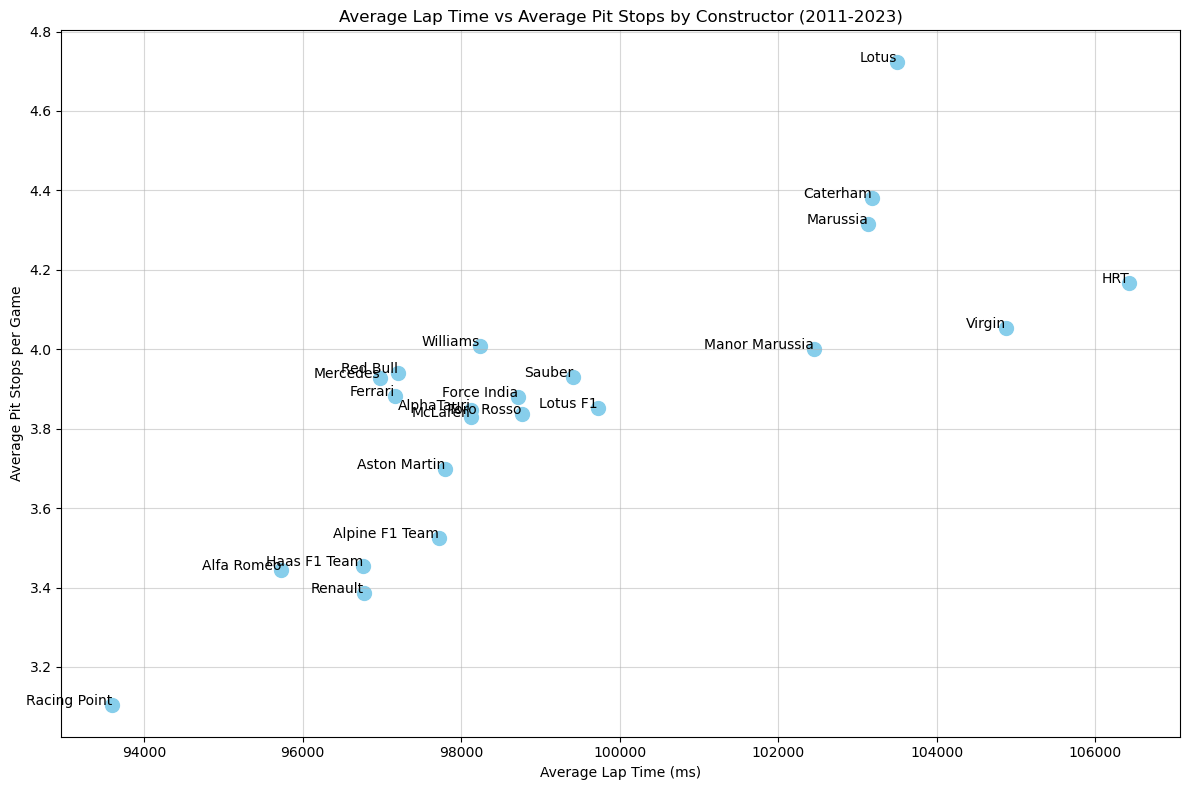

In [33]:
# Plot the scatterplot
plt.figure(figsize=(12, 8))
plt.scatter(constructor_stats['avg_lap_time_ms'], constructor_stats['avg_pit_stops_per_game'], color='skyblue', s=100)

# Add labels for each point
for i, row in constructor_stats.iterrows():
    plt.text(row['avg_lap_time_ms'], row['avg_pit_stops_per_game'], row['constructor_name'], fontsize=10, ha='right')

# Add titles and labels
plt.title('Average Lap Time vs Average Pit Stops by Constructor (2011-2023)')
plt.xlabel('Average Lap Time (ms)')
plt.ylabel('Average Pit Stops per Game')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()